# Runtime Benchmarking

## Environment settings
```sh
# Working Directory
cd Bac2fFeature/scripts/04_runtime_benchmarking
# Conda environment
conda activate bac2feature_experiment
# Output Directory
directories=(
    "../../data/time_calculation"
    "../../data/time_calculation/header"
)
for dir in "${directories[@]}"; do
  if [ ! -d "$dir" ]; then
    mkdir -p "$dir"
  fi
done
```

In [1]:
import json
import os

import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

matplotlib.rcParams['font.family']       = 'Arial'
matplotlib.rcParams['font.sans-serif']   = ["Arial","DejaVu Sans","Lucida Grande","Verdana"]
matplotlib.rcParams['figure.figsize']    = [4,3]
matplotlib.rcParams['font.size']         = 12
matplotlib.rcParams["axes.labelcolor"]   = "#000000"
matplotlib.rcParams["axes.linewidth"]    = 1.0
matplotlib.rcParams["xtick.major.width"] = 1.0
matplotlib.rcParams["ytick.major.width"] = 1.0
cmap1 = plt.cm.tab20
cmap2 = plt.cm.Set3

## Extracting 16S rRNA gene sequences from RNA-central

In [ ]:
# nseqs = np.geomspace(start=100, stop=100000, num=50, endpoint=True, dtype=int)
nseqs = np.arange(start=1000, stop=10000 + 1000, step=1000) # Include endpoint

# This take 4 minutes.
# RNA central id mapping
id_path = "../../data/rnacentral/id_mapping.tsv"
cols = ["rnacentral-id", "source", "_1", "_2", "type", "comment"]
id_mapping = pd.read_csv(id_path, sep="\t", dtype=str, names=cols)
id_mapping = id_mapping.fillna("")
# NR
id_mapping_nr = id_mapping.drop_duplicates(subset="rnacentral-id", keep="first")
# Only GreenGenes
test_flag = (id_mapping_nr["source"]=="GREENGENES") & (id_mapping_nr["type"]=="rRNA") & (id_mapping_nr["comment"]=="rrn")
testdata = id_mapping_nr[test_flag]
testdata = testdata.reset_index(drop=True)
# Save
id_gg_path = "../../data/time_calculation/id_mapping_gg.tsv"
testdata.to_csv(id_gg_path, sep="\t", index=False)
seed = np.arange(0, len(nseqs), 1)
for n, s in zip(nseqs, seed):
    header_path = f"../../data/time_calculation/header/header_{n}.txt"
    testdata.sample(n=n, random_state=s)["rnacentral-id"].to_csv(header_path, index=False, header=False)

```sh
seqkit fx2tab ../../data/rnacentral/rnacentral_active.fasta > ../../data/time_calculation/rnacentral_active.tsv
```

In [ ]:
def fx2tab_iter(fx2tab_file_path):
    with open(fx2tab_file_path, mode="r", encoding="utf-8") as f:
        for line in f:
            rna_centralid = line.split("\t")[0].split(" ")[0]
            seq = line.split("\t")[1]
            yield rna_centralid, seq

def fx2tab_parser(in_path, out_path, header_path):
    header = pd.read_csv(header_path, header=None)
    s_header = set(list(header[0]))
    with open(out_path, mode="w", encoding="utf-8") as f:
        for rna_centralid, seq in fx2tab_iter(in_path):
            if rna_centralid not in s_header:
                continue
            output = rna_centralid + "\t" + seq + "\n"
            f.write(output)

# It takes 10 mins.
for n in nseqs:
    in_path = "../../data/time_calculation/rnacentral_active.tsv"
    out_path = f"../../data/time_calculation/test/test_seqs_{n}.tsv"
    header_path = f"../../data/time_calculation/header/header_{n}.txt"
    fx2tab_parser(in_path=in_path, out_path=out_path, header_path=header_path)

```sh
# Convert to fasta file
ls ../../data/time_calculation/test/*.tsv | sed "s/.tsv//g" | xargs -I{} seqkit tab2fx {}.tsv --out-file {}.fasta
```

## Runtime benchmarking

```sh
python3 calc_time.py homology
python3 calc_time.py taxonomy
python3 calc_time.py phylogeny
```

## Visualization

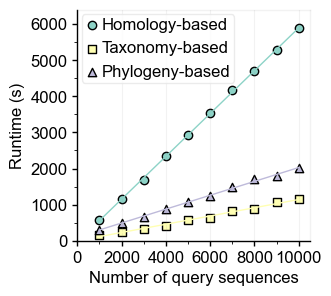

In [5]:
# Result path
methods = ["homology", "taxonomy", "phylogeny"]
colors = ["#8DD3C7", "#FFFFB3", "#BEBADA"]
markers = ['o', 's', '^']

path = [f"../../data/time_calculation/time_{method}.tsv" for method in methods]

# Plot
fig, ax = plt.subplots(figsize=(3, 3))

for p, c, m in zip(path, colors, markers):
    time = pd.read_csv(p, sep="\t")
    x, y = time["nseqs"].values, time["wall_time"].values
    # Scatter
    ax.scatter(x, y, c=c, edgecolor='black', marker=m)

ax.legend(["Homology-based", "Taxonomy-based", "Phylogeny-based"],
          bbox_to_anchor=(0.02, 0.98), loc='upper left',
          edgecolor=(0.9, 0.9, 0.9), facecolor='white', borderaxespad=0,
          handlelength=0.8, # 凡例ハンドルの長さを短くする。デフォルトは2.0em
          handletextpad=0.2, # 凡例ハンドルと文字の間隔を狭くする。デフォルトは0.8em。
        #   borderaxespad=0.2, # 凡例とグラフの軸の間隔を狭くする。デフォルトは0.5em。
          borderpad=0.2 # 凡例枠の余白を狭くする。デフォルトは0.5em。
          )

for p, c in zip(path, colors):
    time = pd.read_csv(p, sep="\t")
    x, y = time["nseqs"].values, time["wall_time"].values
    # Fitting linear model
    lr = LinearRegression()
    lr.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    ax.plot(x, lr.predict(x.reshape(-1, 1)), linewidth=1, color=c)

ax.xaxis.set_major_locator(MultipleLocator(2000))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1000))

ax.yaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(500))

ax.grid(axis='x', alpha=0.1, color='grey')

ax.set_xlim(0, 10500)
ax.set_ylim(0, 6400)

ax.set_xlabel("Number of query sequences")
ax.set_ylabel("Runtime (s)")

ax.spines['top'].set(alpha=0.1, color='grey')
ax.spines['right'].set(alpha=0.1, color='grey')

plt.savefig("../../results/04_runtime_benchmarking/fig2c.pdf",
            format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)